In [1]:
from vibegrad import Tensor

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        # Safely extract scalars from n.data
        try:
            data = n.data.item() if hasattr(n.data, 'item') else float(n.data)
        except (ValueError, TypeError):
            data = 0.0  # Default value if n.data is invalid

        # Safely extract scalars from n.grad
        try:
            grad = n.grad.item() if hasattr(n.grad, 'item') else float(n.grad)
        except (ValueError, TypeError, AttributeError):
            grad = 0.0  # Default value if n.grad is invalid

        # Create a rectangular ('record') node for each value in the graph
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, data, grad),
            shape='record'
        )
        if n._op:
            # Create an op node if this value is a result of an operation
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot




In [3]:
a = Tensor(2)
b = Tensor(4)

In [4]:
import numpy as np
c = Tensor(1)
c.data

array(1.)

In [5]:
c = a*b
c.backward()
c.grad

array(1.)

In [6]:
b.grad, a.grad

(array(2.), array(4.))

In [7]:
c.zero_grad()
a.zero_grad()
b.zero_grad()

In [8]:
from vibegrad.nn import Linear, Sequential

In [9]:
a = Linear(1, 1)

In [10]:
import numpy as np
np.random.uniform((1,1))

array([1., 1.])

In [11]:
a(Tensor([1]))

Tensor(data=[0.06805869])

In [12]:
a.weight, a.bias

(Tensor(data=[[0.06805869]]), Tensor(data=[0.]))

In [13]:
import torch
from torch.nn import Linear as tLinear

In [14]:
a = tLinear(1,1)

In [15]:
a(torch.tensor([1.0]))

tensor([-0.9875], grad_fn=<ViewBackward0>)

In [16]:
a.weight, a.bias

(Parameter containing:
 tensor([[-0.8889]], requires_grad=True),
 Parameter containing:
 tensor([-0.0985], requires_grad=True))

In [17]:
from vibegrad.nn import *
from vibegrad.optims import *

In [18]:
model = Sequential([
    Linear(256, 300),
    ReLU(),
    Linear(300, 1),
    Sigmoid()
])
for param in model.parameters:
    print(param.data.shape)
    print(param.grad)
for layer in model.layers:
    if hasattr(layer, 'weight'):
        print("hi")
        print(layer.weight.grad)
        print(layer.bias.grad)
type(model.parameters)

(256, 300)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(300,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0

list

In [19]:
input_data = Tensor(np.random.randn(10, 256).astype(np.float32))

output_data = Tensor(np.random.randint(0, 2, size=(10, 1)).astype(np.float32))

print("Input data shape:", input_data.shape)
print("Output data shape:", output_data.shape)

Input data shape: (10, 256)
Output data shape: (10, 1)


In [20]:
loss_fn = MSELoss()
optim = SGD(model.parameters, 1.0)

Tensor(data=0.22791561097955823)
Tensor(data=0.22791561097955823)
Tensor(data=0.22791561097955823)
Tensor(data=0.22791561097955823)
Tensor(data=0.22791561097955823)
Tensor(data=0.22791561097955823)
Tensor(data=0.22791561097955823)
Tensor(data=0.22791561097955823)
Tensor(data=0.22791561097955823)
Tensor(data=0.22791561097955823)


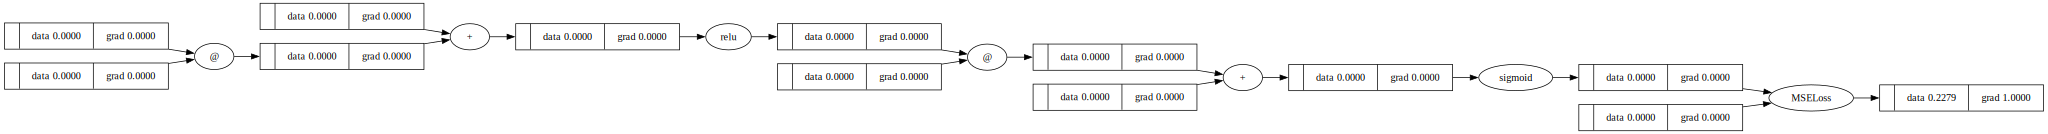

In [21]:
for _ in range(10):
    logits = model(input_data)
    loss = loss_fn(logits, output_data)
    optim.zero_grad()
    loss.backward()
    optim.step()
    print(loss)
draw_dot(loss)

In [22]:
a = np.array(1)
b = np.array(np.arange(10)).reshape(10,1)
print(a,b)
a + b

1 [[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]


array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])

In [23]:
model_torch = torch.nn.Sequential(
    torch.nn.Linear(256, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, 1),
    torch.nn.Sigmoid()
)
model_torch.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=256, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=1, bias=True)
  (5): Sigmoid()
)>

In [24]:
input_data = torch.Tensor(np.random.randn(10, 256).astype(np.float32))
output_data = torch.Tensor(np.random.randint(0, 2, size=(10, 1)).astype(np.float32))

loss_fn = torch.nn.BCELoss()
optim = torch.optim.SGD(model_torch.parameters(), 0.1, momentum=0.0)

for _ in range(10):
    logits = model_torch(input_data)
    loss = loss_fn(logits, output_data)
    loss.backward()
    optim.step()
    optim.zero_grad()
    print(loss)

tensor(0.6688, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6268, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5877, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5485, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5084, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4663, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4224, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3774, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3326, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2896, grad_fn=<BinaryCrossEntropyBackward0>)


In [25]:
model.total_params()

77401

In [26]:
X = np.random.uniform(-1, 1, size=(100, 256))
y = np.random.choice([0, 1], size=(100, 10), p=[0.5, 0.5])
X.shape
X = Tensor(X)
y = Tensor(y) 
y.data[:5]

array([[0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [1, 0, 1, 0, 1, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [1, 0, 0, 1, 0, 1, 1, 1, 1, 1]])

In [27]:
out = model(X)
out.data.shape, y.data.shape

ValueError: operands could not be broadcast together with shapes (100,300) (10,300) 

In [26]:
prediction = Tensor(np.array([0.9, 0.4, 0.7, 0.2]))
target = Tensor(np.array([1, 0, 1, 0]))

loss_fn = BCELoss(reduction="sum")
loss = loss_fn(prediction, target)
print(loss)
loss.backward()
prediction.grad

Tensor(data=1.1960046346767592)


array([-1.11111111,  1.66666667, -1.42857143,  1.25      ])

In [27]:
prediction = torch.tensor(np.array([0.9, 0.4, 0.7, 0.2]), requires_grad=True)
target = torch.tensor(np.array([1,0,1,0]), dtype=torch.double, requires_grad=True)
loss_fn_torch = torch.nn.BCELoss(reduction="sum")
loss_torch = loss_fn_torch(prediction, target)
print(loss_torch)
loss_torch.backward()
prediction.grad

tensor(1.1960, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)


tensor([-1.1111,  1.6667, -1.4286,  1.2500], dtype=torch.float64)

In [28]:
model = torch.nn.Sequential()
model.append(torch.nn.Linear(256, 300))
model.append(torch.nn.Linear(300,300))
model.append(torch.nn.Linear(300,10))

Sequential(
  (0): Linear(in_features=256, out_features=300, bias=True)
  (1): Linear(in_features=300, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=10, bias=True)
)

In [29]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 170410


In [30]:
model.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=256, out_features=300, bias=True)
  (1): Linear(in_features=300, out_features=300, bias=True)
  (2): Linear(in_features=300, out_features=10, bias=True)
)>

In [31]:
import vibegrad.nn as nn

In [32]:
nn.relu(Tensor(2.0))

Tensor(data=2.0)

In [32]:
import numpy as np

# Example: Broadcasting shapes
shape1 = (1,)
shape2 = (10, 1)
arr1 = np.random.randn(1)
arr2 = np.random.randn(10,1)

# np.broadcast_shapes(shape1, shape2), np.broadcast_shapes(shape2, shape1)
arr1 += arr2

ValueError: non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (10,1)

In [34]:
arr3 = np.broadcast_to(arr1, arr2.shape)

In [36]:
arr2 += arr3